In [3]:
import slmpy ##https://github.com/wavefrontshaping/slmPy?tab=readme-ov-file
import numpy as np
import time
import matplotlib.pyplot as plt


In [4]:
import numpy as np
import math as mt 
import matplotlib.pyplot as plt
import scipy.special as sci
from matplotlib.animation import FuncAnimation
import tqdm as tqdm
from matplotlib.colors import LinearSegmentedColormap
import time as time
from matplotlib import rc
colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)

cm1 = LinearSegmentedColormap.from_list(
        "Custom", [(1,0,0),(0,0,0)], N=20)



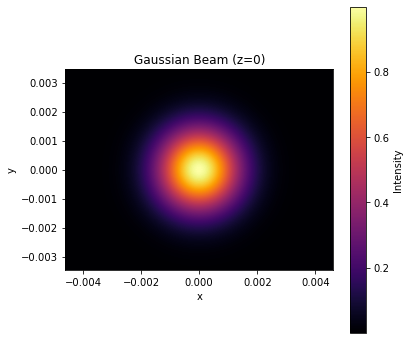

In [5]:

Nxpix = 1024
Nypix = 768
Pix_size=9e-6

##GENERACION DE BEAMS GAUSSIANOS

def gaussian_beam(r, z, w0, k):
    """
    Computes the Gaussian beam profile based on the given equation.
    
    Parameters:
        r  : Radial coordinate
        z  : Axial coordinate (propagation distance)
        w0 : Beam waist (radius at focus)
        k  : Wave number
    
    Returns:
        Complex field amplitude of the Gaussian beam.
    """
    z_R = np.pi * w0**2 / k  # Rayleigh range
    w_z = w0 * np.sqrt(1 + (z / z_R) ** 2)  # Beam waist at z
    R_z = z * (1 + (z_R / z) ** 2) if z != 0 else np.inf  # Radius of curvature
    psi_z = np.arctan(z / z_R)  # Gouy phase
    
    amplitude = (w0 / w_z) * np.exp(-r**2 / w_z**2)
    phase = np.exp(-1j * (k * z + k * r**2 / (2 * R_z) - psi_z))
    
    return amplitude * phase

# Define grid
N = (Nxpix,Nypix)  # Grid size
x = np.linspace(-Nxpix/2*Pix_size, Nxpix/2*Pix_size, Nxpix)
y = np.linspace(-Nypix/2*Pix_size, Nypix/2*Pix_size, Nypix)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)


# Set Gaussian beam parameters
w0 = 2000* 10**-6  # Beam waist
z = 0  # Propagation distance
k = 2*np.pi/633e-9  # Wave number

# Compute beam intensity
gaussian_mode = gaussian_beam(R, z, w0, k)
intensity = np.abs(gaussian_mode) ** 2

# Plot the intensity pattern
plt.figure(figsize=(6, 6))
plt.imshow(intensity, extent=[-Nxpix/2*Pix_size, Nxpix/2*Pix_size, -Nypix/2*Pix_size, Nypix/2*Pix_size], cmap='inferno')
plt.colorbar(label='Intensity')
plt.title(f'Gaussian Beam (z={z})')
plt.xlabel('x')
plt.ylabel('y')
plt.show()




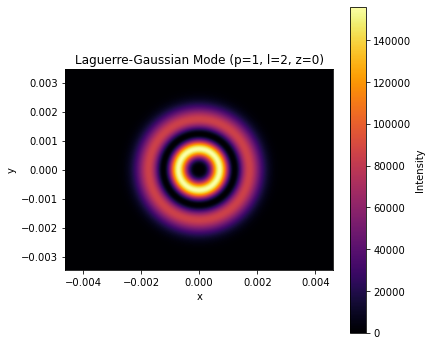

<Figure size 432x288 with 0 Axes>

In [6]:

##GENERAR MODOS LAGUERRE GAUSS

from scipy.special import genlaguerre

def laguerre_gauss_mode(p, l, r, phi, z, w0, k):
    """
    Computes the Laguerre-Gaussian mode of light.
    
    Parameters:
        p  : Radial index (non-negative integer)
        l  : Azimuthal index (integer)
        r  : Radial coordinate
        phi: Azimuthal coordinate
        z  : Propagation distance
        w0 : Beam waist
        k  : Wave number
    
    Returns:
        Complex field amplitude of the LG mode.
    """
    z_R = np.pi * w0**2 / k  # Rayleigh range
    w_z = w0 * np.sqrt(1 + (z / z_R) ** 2)  # Beam waist at z
    R_z = z * (1 + (z_R / z) ** 2) if z != 0 else np.inf  # Radius of curvature
    psi_z = np.arctan(z / z_R)  # Gouy phase
    
    C_lp = np.sqrt(2 * np.math.factorial(p) / (np.pi * np.math.factorial(p + abs(l))))
    R = np.sqrt(2) * r / w_z
    L = genlaguerre(p, abs(l))(2 * r**2 / w_z**2)  # Generalized Laguerre polynomial
    
    amplitude = C_lp * (R**abs(l)) * np.exp(-r**2 / w_z**2) * L
    phase = np.exp(-1j * k * r**2 / (2 * R_z)) * np.exp(-1j * l * phi) * np.exp(1j * psi_z)
    
    return (1 / w_z) * amplitude * phase

# Define grid
N = (Nxpix,Nypix)  # Grid size
x = np.linspace(-Nxpix/2*Pix_size, Nxpix/2*Pix_size, Nxpix)
y = np.linspace(-Nypix/2*Pix_size, Nypix/2*Pix_size, Nypix)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
Phi = np.arctan2(Y, X)


# Set LG mode indices and parameters
p, l = 1, 2  # Example mode numbers
w0 = 1000* 10**-6  # Beam waist
z = 0  # Propagation distance
k = 2*np.pi/633e-9  # Wave number

# Compute mode intensity
LG_mode = laguerre_gauss_mode(p, l, R, Phi, z, w0, k)
intensity = np.abs(LG_mode) ** 2

# Plot the intensity pattern
plt.figure(figsize=(6, 6))
plt.imshow(intensity, extent=[-Nxpix/2*Pix_size, Nxpix/2*Pix_size, -Nypix/2*Pix_size, Nypix/2*Pix_size], cmap='inferno')
plt.colorbar(label='Intensity')
plt.title(f'Laguerre-Gaussian Mode (p={p}, l={l}, z={z})')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.savefig(f'Laguerre-Gaussian Mode (p={p}, l={l}, z={z}).jpeg')


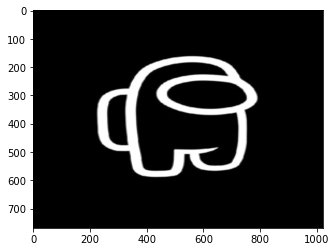

In [7]:
##IMPORTAR IMAGEN/HOLOGRAMA

import cv2


def resize_image_to_matrix(image_path, width, height):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    if image is None:
        raise ValueError("Image not found or unable to load.")
    
    # Resize the image
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    
    # Convert to a NumPy array with values between 0 and 255
    pixel_matrix = np.array(resized_image, dtype=np.uint8)
    
    pixel_matrix= cv2.bitwise_not(pixel_matrix) 
    
    return pixel_matrix


Figure=resize_image_to_matrix("Amongus.jpg",1024,768)


pattern=plt.imshow(Figure,cmap="gray")

(768, 1024)


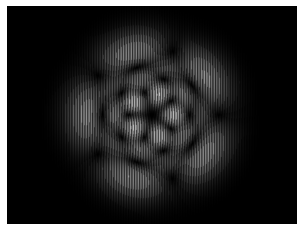

In [25]:

Nxpix = 1024
Nypix = 768
pix_size=9e-6






##GENERACION DE PATRONES AMPLITUD FASE SEGUN (E.Bolduc,2013) "Exact solution to simultaneous intensity and phase encryption with a single phase-only hologram"

def Amplitude_Phase_pattern(Desired_Field,LAMBDA,NX,NY):
    
    A=np.absolute(Desired_Field)
    PHI=np.angle(Desired_Field)
    
    
    
    M=A/np.max(A)
    F=PHI-np.pi*M
    
    
    print(np.shape(M))
    
    psi=np.zeros([NY,NX])
    
 
    
    for n in range(NY):
        for m in range(NX):
            
            
            psi[n,m]=M[n,m]*np.mod(F[n,m] +  2*np.pi*m/LAMBDA, 2*np.pi)
         
    
    
    psi_int=((psi - psi.min()) * (1/(psi.max() - psi.min()) * 255)).astype('uint8')
    
    return  psi_int



Output_Field=laguerre_gauss_mode(2, -2, R, Phi, z, 1000e-6, k)+laguerre_gauss_mode(1, 3, R, Phi, z, 1000e-6, k)
LG0_1=laguerre_gauss_mode(0, 3, R, Phi, z, w0, k)
Hologram=Amplitude_Phase_pattern(Output_Field,pix_size,Nxpix,Nypix)

pattern=plt.imshow(Hologram,cmap="gray",aspect='equal')
#Field_int=plt.imshow(np.abs(Output_Field)**2,cmap="gray")
plt.axis('off')
plt.savefig("Hologram.jpeg",bbox_inches='tight', transparent="True", pad_inches=0)






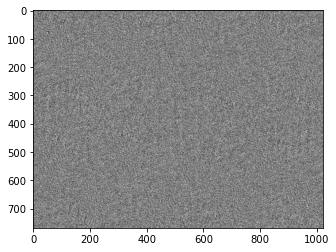

In [21]:
## FFT DE IMAGEN

from scipy.fft import ifftn


import cv2


def resize_image_to_matrix(image_path, width, height):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    if image is None:
        raise ValueError("Image not found or unable to load.")
    
    # Resize the image
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    
    # Convert to a NumPy array with values between 0 and 255
    pixel_matrix = np.array(resized_image, dtype=np.uint8)
    
    pixel_matrix= cv2.bitwise_not(pixel_matrix) 
    
    return pixel_matrix


Figure=resize_image_to_matrix("Amongus.jpg",1024,768)


FFTHologram=ifftn(Figure)
plt.imshow(np.angle(FFTHologram),cmap="gray")
plt.savefig("FFT.jpeg",bbox_inches='tight', transparent="True", pad_inches=0)




In [28]:

import cv2
import screeninfo

def show_fullscreen_image(image_path, screen_index=0):
    # Load the image
    image = cv2.imread(image_path)
    
    # Check if image is loaded successfully
    if image is None:
        print("Error: Unable to load image.")
        return
    
    # Get screen dimensions
    screens = screeninfo.get_monitors()
    if screen_index >= len(screens):
        print("Error: Screen index out of range.")
        return
    
    screen = screens[screen_index]
    screen_width, screen_height = screen.width, screen.height
    
    # Resize the image to fit the screen dimensions
    image = cv2.resize(image, (screen_width, screen_height))
    
    # Create a named window and move it to the selected screen
    cv2.namedWindow("Fullscreen Image", cv2.WND_PROP_FULLSCREEN)
    cv2.moveWindow("Fullscreen Image", screen.x, screen.y)
    cv2.setWindowProperty("Fullscreen Image", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    
    # Show the image
    cv2.imshow("Fullscreen Image", image)
    
    # Wait for a key press and close the window
    cv2.waitKey(0)
    cv2.destroyAllWindows()

show_fullscreen_image("Hologram.jpeg",screen_index=0)
